In [1]:
import calendar
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.linear_model import LinearRegression,Lasso,Ridge
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.feature_selection import RFE


In [2]:
df = pd.read_csv("train.csv")

In [3]:
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [5]:
cat_cols = df.select_dtypes(include=np.object_).columns.values

In [6]:
#As per the data definition below columns are categorical in nature.
df['MSSubClass'] = df.MSSubClass.astype('category')
df['OverallQual'] = df.OverallQual.astype('category')
df['OverallCond'] = df.OverallCond.astype('category')
cat_cols = df.select_dtypes(include='category').columns.values
len(cat_cols)

3

In [7]:
num_cols = df.select_dtypes(include=np.number).columns.values
num_cols

array(['Id', 'LotFrontage', 'LotArea', 'YearBuilt', 'YearRemodAdd',
       'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
       'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch',
       'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SalePrice'],
      dtype=object)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Id             1460 non-null   int64   
 1   MSSubClass     1460 non-null   category
 2   MSZoning       1460 non-null   object  
 3   LotFrontage    1201 non-null   float64 
 4   LotArea        1460 non-null   int64   
 5   Street         1460 non-null   object  
 6   Alley          91 non-null     object  
 7   LotShape       1460 non-null   object  
 8   LandContour    1460 non-null   object  
 9   Utilities      1460 non-null   object  
 10  LotConfig      1460 non-null   object  
 11  LandSlope      1460 non-null   object  
 12  Neighborhood   1460 non-null   object  
 13  Condition1     1460 non-null   object  
 14  Condition2     1460 non-null   object  
 15  BldgType       1460 non-null   object  
 16  HouseStyle     1460 non-null   object  
 17  OverallQual    1460 non-null   ca

In [9]:
# before removing the columns iwth maximum null values, lets chheck how important they are.
# list all thehe columns with missing values
s = df.isnull().sum(axis=0)>0
col_with_nan = s.index[s].values
col_with_nan


array(['LotFrontage', 'Alley', 'MasVnrType', 'MasVnrArea', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Electrical', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence',
       'MiscFeature'], dtype=object)

In [10]:
num_col_nan = []
for col in col_with_nan:
    if col in num_cols:
        num_col_nan.append(col)
print(num_col_nan)
        

['LotFrontage', 'MasVnrArea', 'GarageYrBlt']


##### GarageYrBlt is type date will handle it separtely

In [11]:
# Handle columns with null values
# forr type numerical lets put median as the missing value
# for type categorical lets put mode as the missign value if data dic doesnt have NA 
df['LotFrontage'].fillna(df['LotFrontage'].median(),inplace=True)
df['MasVnrArea'].fillna(df['MasVnrArea'].median(),inplace=True)

cat_nan_column = ['Alley','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1', 'BsmtFinType2','FireplaceQu','GarageType','GarageFinish','GarageQual','GarageCond','PoolQC', 'Fence',
       'MiscFeature']
for cat_col in cat_nan_column:
    df[cat_col].fillna('NA',inplace=True)
    print(df[cat_col].value_counts())
    
#     
cols=['MasVnrType','Electrical']
for col in cols:
    df[col].fillna(df[col].mode()[0],inplace=True)
    print(df[col].value_counts())

NA      1369
Grvl      50
Pave      41
Name: Alley, dtype: int64
TA    649
Gd    618
Ex    121
NA     37
Fa     35
Name: BsmtQual, dtype: int64
TA    1311
Gd      65
Fa      45
NA      37
Po       2
Name: BsmtCond, dtype: int64
No    953
Av    221
Gd    134
Mn    114
NA     38
Name: BsmtExposure, dtype: int64
Unf    430
GLQ    418
ALQ    220
BLQ    148
Rec    133
LwQ     74
NA      37
Name: BsmtFinType1, dtype: int64
Unf    1256
Rec      54
LwQ      46
NA       38
BLQ      33
ALQ      19
GLQ      14
Name: BsmtFinType2, dtype: int64
NA    690
Gd    380
TA    313
Fa     33
Ex     24
Po     20
Name: FireplaceQu, dtype: int64
Attchd     870
Detchd     387
BuiltIn     88
NA          81
Basment     19
CarPort      9
2Types       6
Name: GarageType, dtype: int64
Unf    605
RFn    422
Fin    352
NA      81
Name: GarageFinish, dtype: int64
TA    1311
NA      81
Fa      48
Gd      14
Ex       3
Po       3
Name: GarageQual, dtype: int64
TA    1326
NA      81
Fa      35
Gd       9
Po       7
Ex   

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Id             1460 non-null   int64   
 1   MSSubClass     1460 non-null   category
 2   MSZoning       1460 non-null   object  
 3   LotFrontage    1460 non-null   float64 
 4   LotArea        1460 non-null   int64   
 5   Street         1460 non-null   object  
 6   Alley          1460 non-null   object  
 7   LotShape       1460 non-null   object  
 8   LandContour    1460 non-null   object  
 9   Utilities      1460 non-null   object  
 10  LotConfig      1460 non-null   object  
 11  LandSlope      1460 non-null   object  
 12  Neighborhood   1460 non-null   object  
 13  Condition1     1460 non-null   object  
 14  Condition2     1460 non-null   object  
 15  BldgType       1460 non-null   object  
 16  HouseStyle     1460 non-null   object  
 17  OverallQual    1460 non-null   ca

In [13]:
df[['YearBuilt','YearRemodAdd','GarageYrBlt','YrSold']][df['GarageYrBlt'].isnull()].head()

,YearBuilt,YearRemodAdd,GarageYrBlt,YrSold
39,1955,1955,NaN,2008
48,1920,2008,NaN,2009
78,1968,1968,NaN,2010
88,1915,1982,NaN,2009
89,1994,1995,NaN,2007


In [14]:
#### Handling dates
# col GarageYrBlt hhave missing values from above
date_col = ['YearBuilt','YearRemodAdd','GarageYrBlt','YrSold']

for d_col in date_col:
    print(d_col +" - "+ str(df[d_col].isnull().sum()))
    
df['house_age']=df['YrSold']-df['YearBuilt']
df['remodel_age']=df['YrSold']-df['YearRemodAdd']
# For GarageType as NA , there is no GarageYrBlt , which makes sense since property doesnt hahve garage.
# So binning GarageYrBlt to make it categorical type 
print("Total GarageYrBlt not present for GarageType " + str(df['GarageYrBlt'][df['GarageType']== 'NA'].isnull().sum()))
bins = [1899,1920,1940,1960,1980,2000,2020]
labels = ['1900_1920','1921-1940','1941-1960','1961-1980','1981-2000','2001-2020']
df['Garage_age']=pd.cut(df['GarageYrBlt'],bins,labels=labels)
df['Garage_age'] = df['Garage_age'].astype('object')
df['Garage_age'].fillna('NA',inplace=True)
print(df['Garage_age'].value_counts())




YearBuilt - 0
YearRemodAdd - 0
GarageYrBlt - 81
YrSold - 0
Total GarageYrBlt not present for GarageType 81
2001-2020    375
1961-1980    367
1981-2000    303
1941-1960    211
1921-1940     92
NA            81
1900_1920     31
Name: Garage_age, dtype: int64


In [15]:
# Dropping date_cols 
df.drop(date_col,axis =1,inplace=True)

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Id             1460 non-null   int64   
 1   MSSubClass     1460 non-null   category
 2   MSZoning       1460 non-null   object  
 3   LotFrontage    1460 non-null   float64 
 4   LotArea        1460 non-null   int64   
 5   Street         1460 non-null   object  
 6   Alley          1460 non-null   object  
 7   LotShape       1460 non-null   object  
 8   LandContour    1460 non-null   object  
 9   Utilities      1460 non-null   object  
 10  LotConfig      1460 non-null   object  
 11  LandSlope      1460 non-null   object  
 12  Neighborhood   1460 non-null   object  
 13  Condition1     1460 non-null   object  
 14  Condition2     1460 non-null   object  
 15  BldgType       1460 non-null   object  
 16  HouseStyle     1460 non-null   object  
 17  OverallQual    1460 non-null   ca

In [17]:
# dropping Id column. 
df.drop('Id',axis =1,inplace=True)

In [18]:
num_cols = df.select_dtypes(include=np.number).columns.values

In [19]:
num_cols

array(['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch',
       'PoolArea', 'MiscVal', 'MoSold', 'SalePrice', 'house_age',
       'remodel_age'], dtype=object)

In [20]:
month = lambda x : calendar.month_name[x]
df['MoSold'] = df.MoSold.map(month)
df['MoSold']

0        February
1             May
2       September
3        February
4        December
          ...    
1455       August
1456     February
1457          May
1458        April
1459         June
Name: MoSold, Length: 1460, dtype: object

In [21]:
df[num_cols].describe(percentiles=[0.25,0.5,0.75,0.9,0.94,0.95,0.96,0.97,0.98])

,LotFrontage,LotArea,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,SalePrice,house_age,remodel_age
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,69.863699,10516.828082,103.117123,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,180921.195890,36.547945,22.950000
std,22.027677,9981.264932,180.731373,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,79442.502883,30.250152,20.640653
min,21.000000,1300.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,34900.000000,0.000000,-1.000000
25%,60.000000,7553.500000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,129975.000000,8.000000,4.000000
50%,69.000000,9478.500000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,163000.000000,35.000000,14.000000
75%,79.000000,11601.500000,164.250000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,214000.000000,54.000000,41.000000
90%,92.000000,14381.700000,335.000000,1065.500000,117.200000,1232.000000,1602.200000,1680.000000,954.200000,0.000000,...,262.000000,130.000000,112.000000,0.000000,0.000000,0.000000,0.000000,278000.000000,84.000000,56.000000
94%,100.000000,16551.900000,425.000000,1225.060000,334.920000,1405.460000,1720.920000,1782.680000,1101.920000,0.000000,...,316.000000,163.840000,162.920000,0.000000,142.460000,0.000000,0.000000,318028.060000,89.000000,58.000000
95%,104.000000,17401.150000,456.000000,1274.000000,396.200000,1468.000000,1753.000000,1831.250000,1141.050000,0.000000,...,335.000000,175.050000,180.150000,0.000000,160.000000,0.000000,0.000000,326100.000000,91.000000,58.000000


##### Summary
- There seems to sudden increase in the value after 95%.
- There seems to outlier above 95% percentile.
- For more details lets check it visually beefore dropping the outlier

In [22]:
cat_cols = df.select_dtypes(exclude=np.number).columns
(cat_cols)

Index(['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour',
       'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',
       'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu',
       'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive',
       'PoolQC', 'Fence', 'MiscFeature', 'MoSold', 'SaleType', 'SaleCondition',
       'Garage_age'],
      dtype='object')

In [23]:
uni_count = {}
for col in cat_cols:
    n = df[col].nunique()
    li = uni_count.get(n)
    if li is None:
        li = []
    li.append(col)
    uni_count[n] = li
print(uni_count)
    
    

{15: ['MSSubClass', 'Exterior1st'], 5: ['MSZoning', 'LotConfig', 'BldgType', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'HeatingQC', 'Electrical', 'Fence', 'MiscFeature'], 2: ['Street', 'Utilities', 'CentralAir'], 3: ['Alley', 'LandSlope', 'PavedDrive'], 4: ['LotShape', 'LandContour', 'MasVnrType', 'ExterQual', 'KitchenQual', 'GarageFinish', 'PoolQC'], 25: ['Neighborhood'], 9: ['Condition1', 'OverallCond', 'SaleType'], 8: ['Condition2', 'HouseStyle', 'RoofMatl'], 10: ['OverallQual'], 6: ['RoofStyle', 'Foundation', 'Heating', 'FireplaceQu', 'GarageQual', 'GarageCond', 'SaleCondition'], 16: ['Exterior2nd'], 7: ['BsmtFinType1', 'BsmtFinType2', 'Functional', 'GarageType', 'Garage_age'], 12: ['MoSold']}


In [24]:
for count, col in uni_count.items():
    print("========== For unique count ", count)
    for c in col:
        print(df[c].value_counts(normalize=True).mul(100).round(1).astype(str) + '%')
    print()

    

========== For unique count  15
20     36.7%
60     20.5%
50      9.9%
120     6.0%
30      4.7%
160     4.3%
70      4.1%
80      4.0%
90      3.6%
190     2.1%
85      1.4%
75      1.1%
45      0.8%
180     0.7%
40      0.3%
Name: MSSubClass, dtype: object
VinylSd    35.3%
HdBoard    15.2%
MetalSd    15.1%
Wd Sdng    14.1%
Plywood     7.4%
CemntBd     4.2%
BrkFace     3.4%
WdShing     1.8%
Stucco      1.7%
AsbShng     1.4%
BrkComm     0.1%
Stone       0.1%
AsphShn     0.1%
ImStucc     0.1%
CBlock      0.1%
Name: Exterior1st, dtype: object

========== For unique count  5
RL         78.8%
RM         14.9%
FV          4.5%
RH          1.1%
C (all)     0.7%
Name: MSZoning, dtype: object
Inside     72.1%
Corner     18.0%
CulDSac     6.4%
FR2         3.2%
FR3         0.3%
Name: LotConfig, dtype: object
1Fam      83.6%
TwnhsE     7.8%
Duplex     3.6%
Twnhs      2.9%
2fmCon     2.1%
Name: BldgType, dtype: object
TA    87.8%
Gd    10.0%
Fa     1.9%
Ex     0.2%
Po     0.1%
Name: ExterCond, dty

#####  Summary
- From above logic we can identify the percentage of value in the total value for the column. basically gives us idea is value occurance is distributed or skewed.
- As we can see most of the columns are skewed. ex :  BldgType ,ExterCond , HeatingQC, BsmtCond etc 
- Having them will not help in the regression will add model complexity. We will drop those columns whhihc are higly skewed.


In [25]:
# Dropping skewed columns
df.drop(['BldgType','ExterCond','BsmtCond','Electrical','Fence','MiscFeature','Street', 'Utilities', 'CentralAir','Alley', 'LandSlope', 'PavedDrive','LandContour','PoolQC','Condition1','SaleType','Condition2','RoofMatl',
'Heating','GarageQual','GarageCond','SaleCondition','BsmtFinType2','Functional'],axis=1,inplace=True)

In [26]:
num_col = df.select_dtypes(include=np.number).columns.values
len(num_col)

31

In [27]:
cat_col = df.select_dtypes(exclude=np.number).columns.values
len(cat_col)

24

### EDA


In [28]:
## plotting num_cols

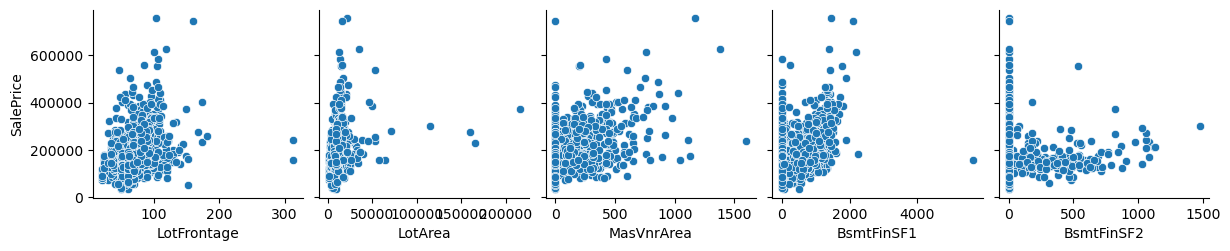

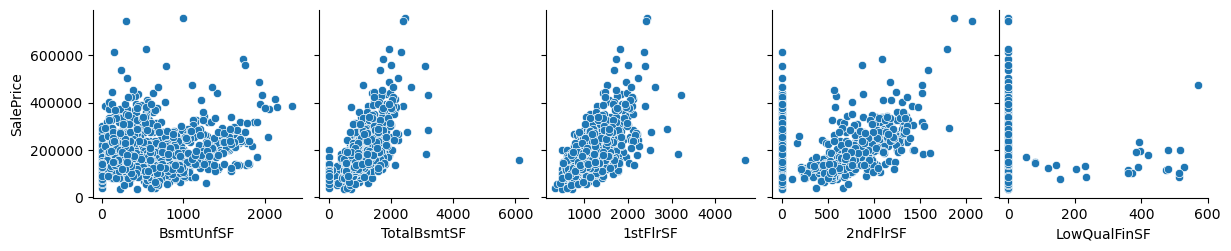

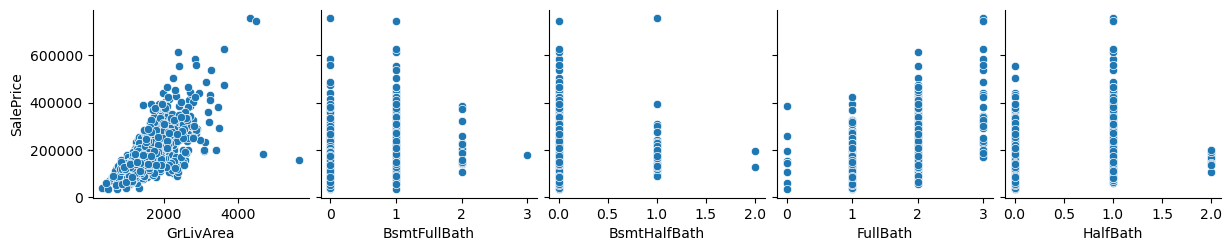

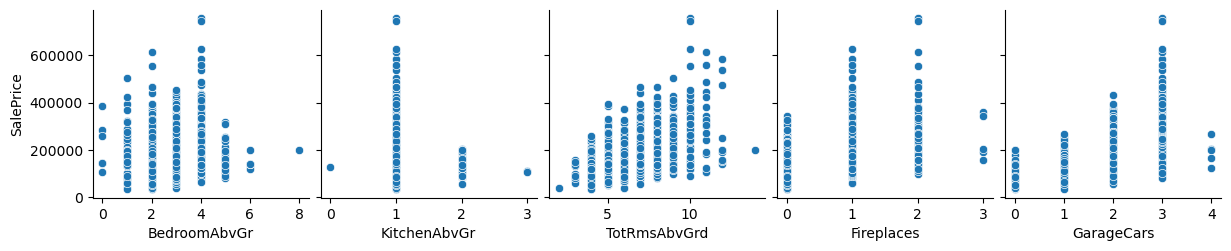

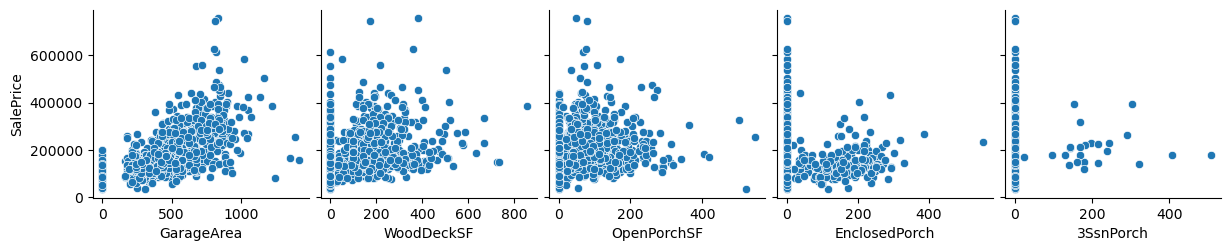

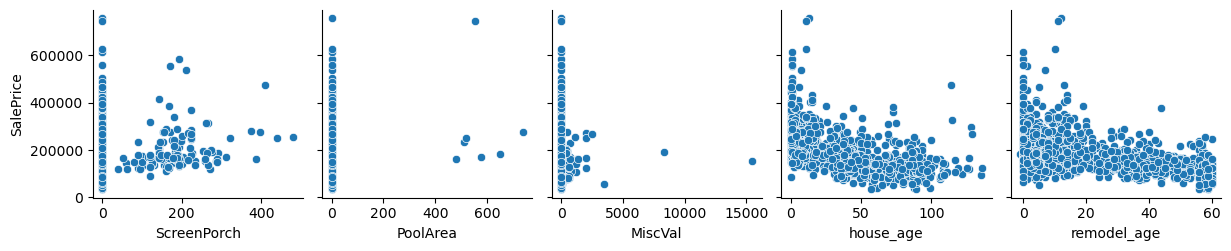

In [29]:
n_cols = num_col
n_cols = np.delete(n_cols, np.where(n_cols == 'SalePrice'))
for cols in n_cols.reshape(6,5):
    a_cols = cols
    cols = np.append(cols,'SalePrice')
    sns.pairplot(data=df[cols], x_vars=a_cols , y_vars='SalePrice')
    plt.show()


In [30]:
## plotting graph for Categorical variable


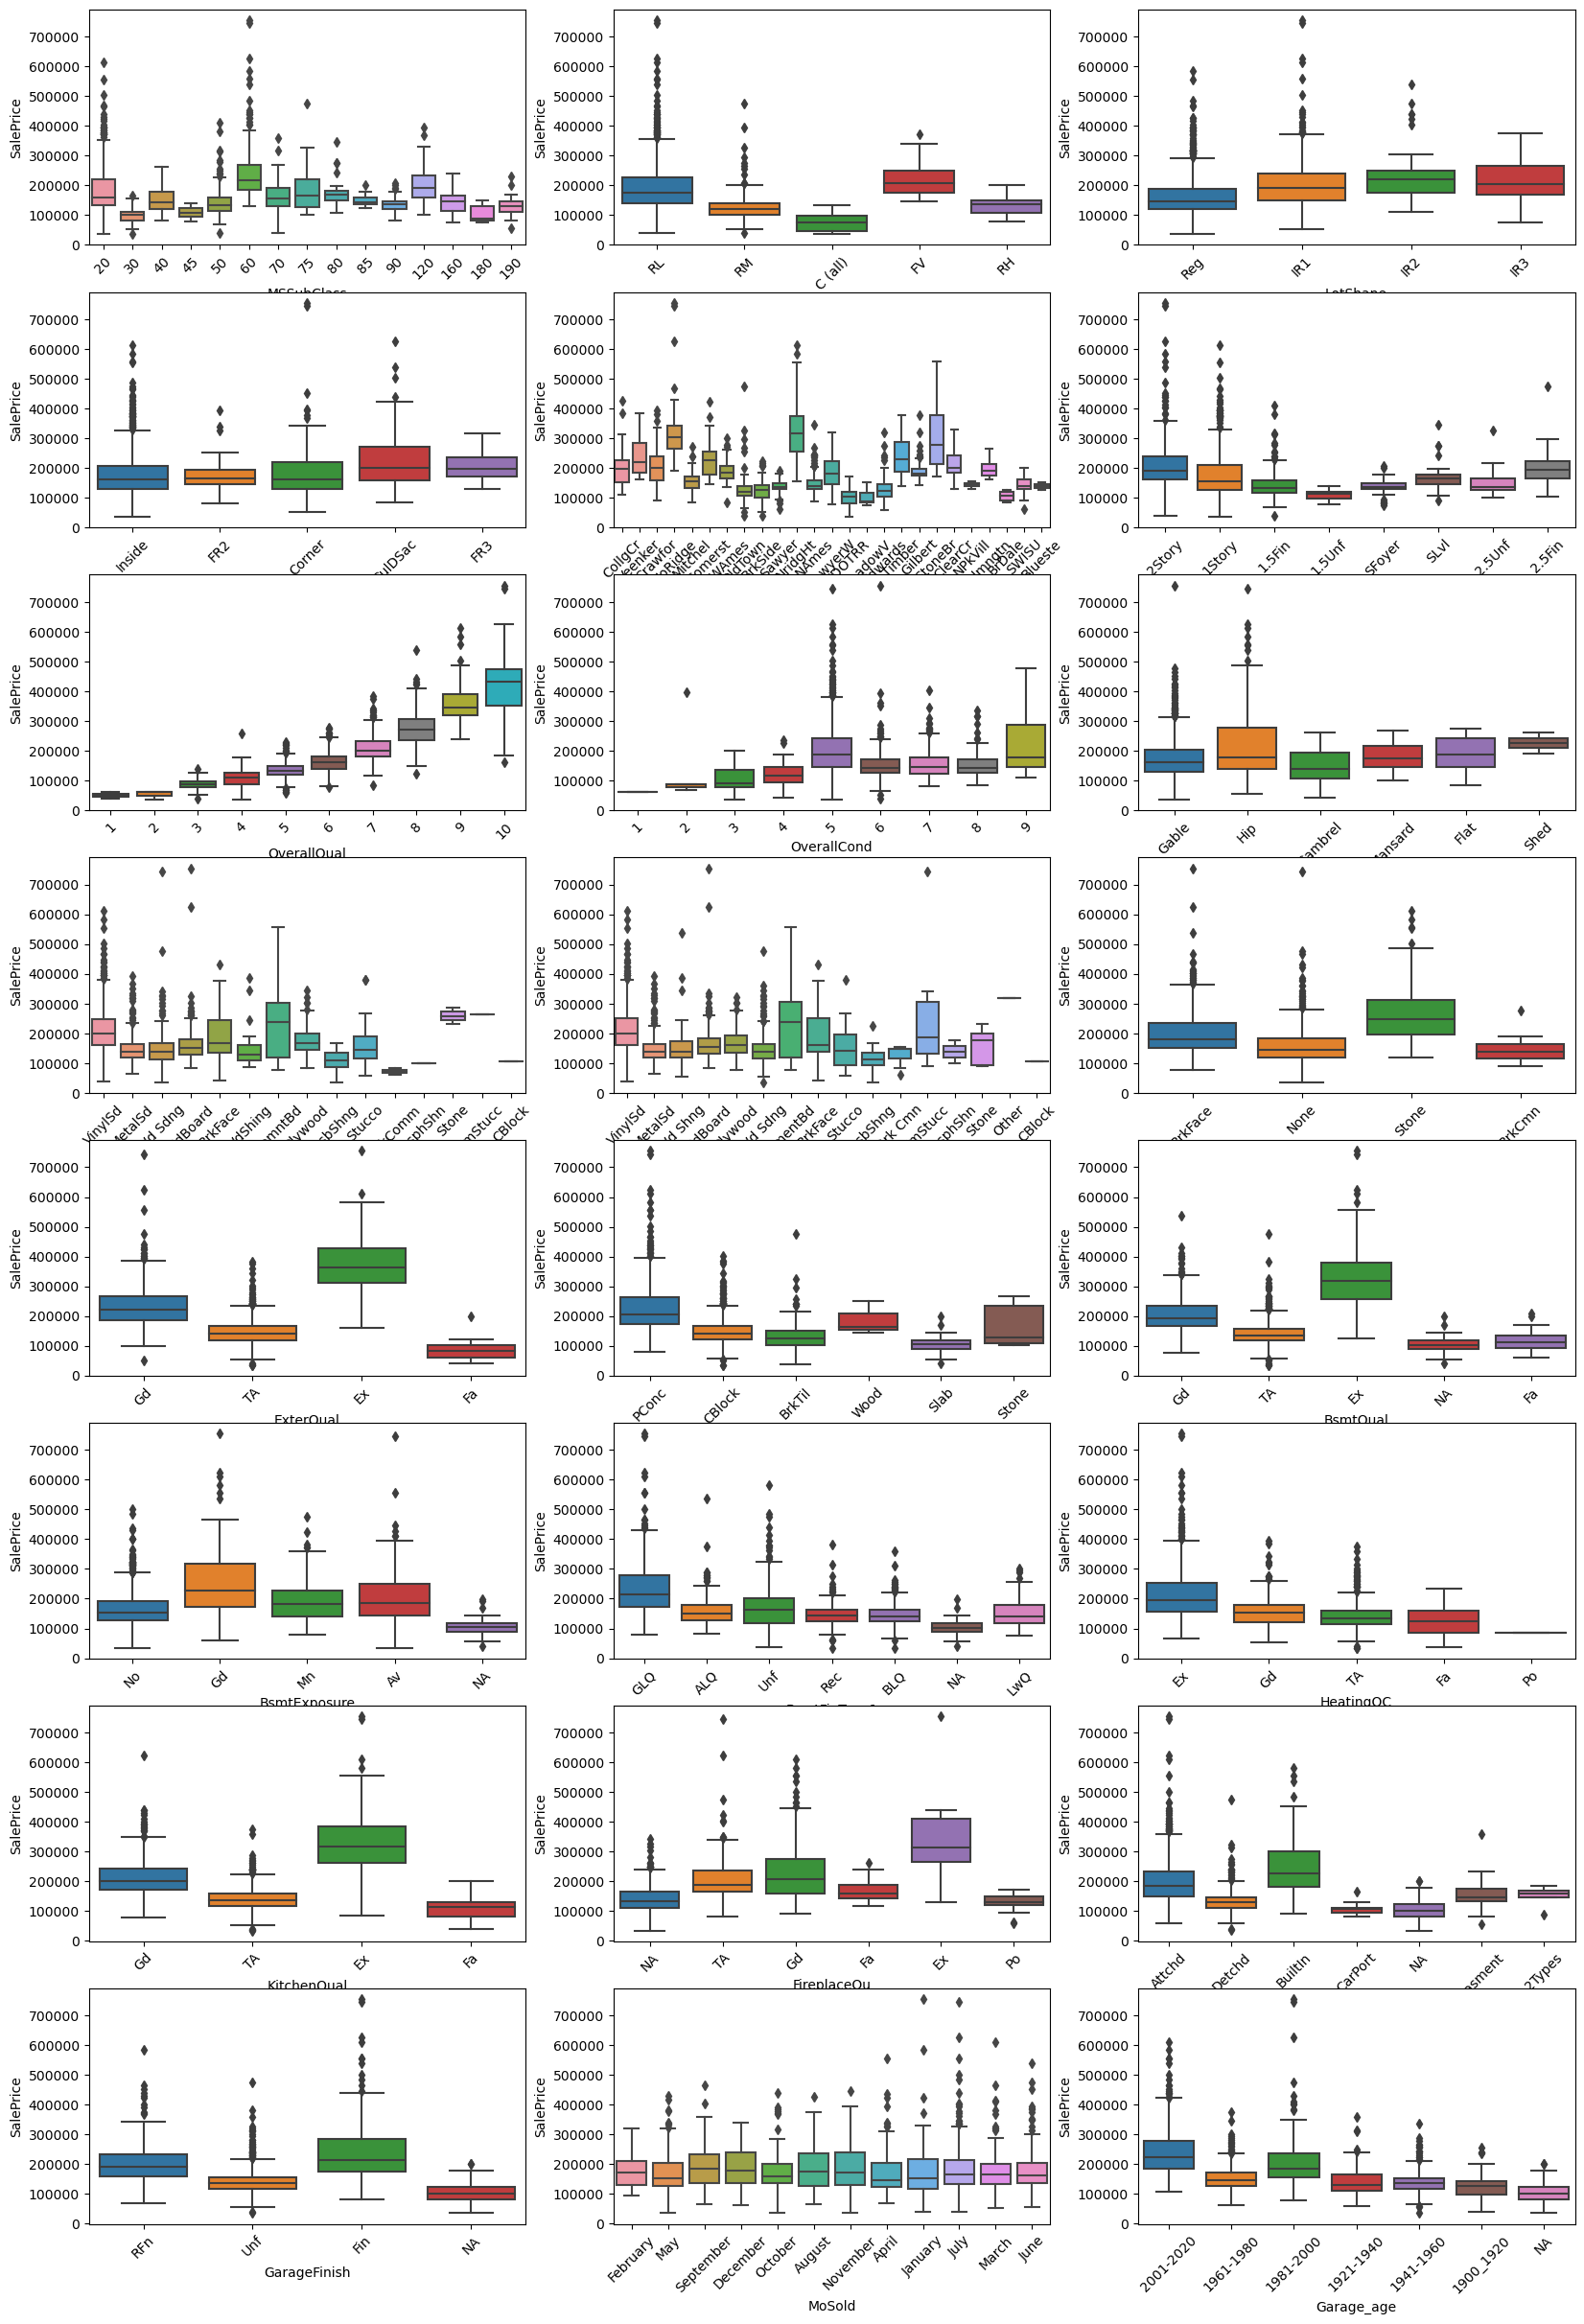

In [31]:
# Function to plot boxplot for categorical variables 
plt.figure(figsize=(20,30))
index=1
for col in cat_col:
    plt.subplot(8,3,index)
    sns.boxplot(x=col,y='SalePrice',data=df)
    plt.xticks(rotation=45)
    index+=1
plt.show()

###### Summary 
- we can infer from the previous percentile and plot outliers are present in both numerical and categorical plot

In [32]:
##### lets try to remove outliers and check the reecords more than 95% percentile
print(len(df[df['SalePrice']>=326100]))
newdf = df[df['SalePrice']<326100]

73


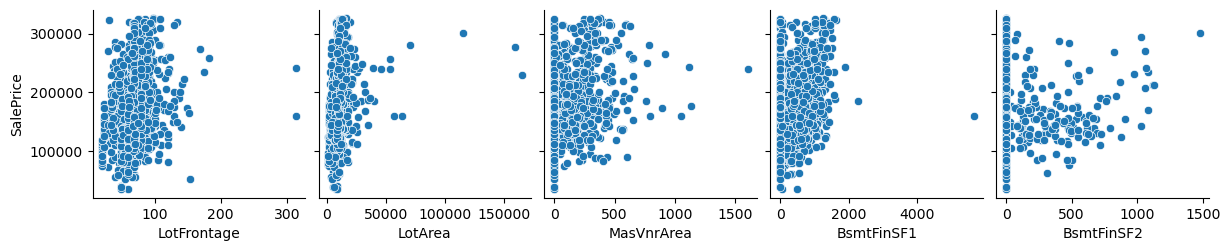

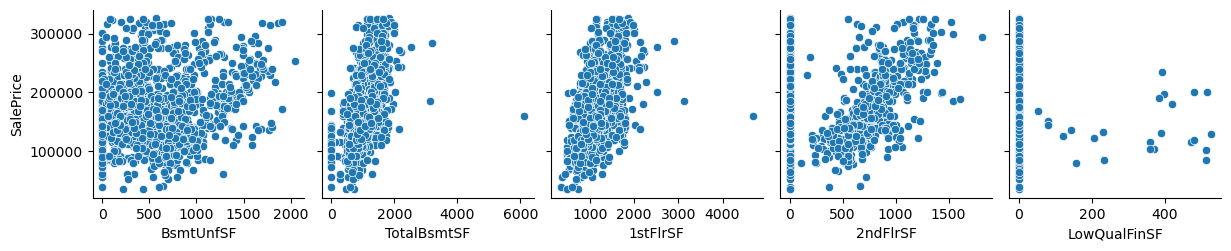

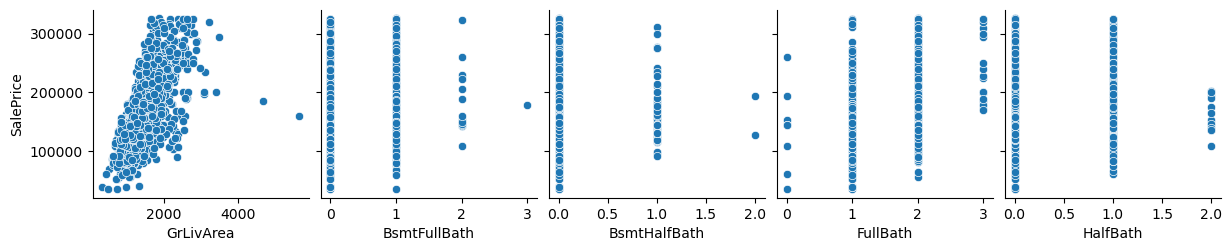

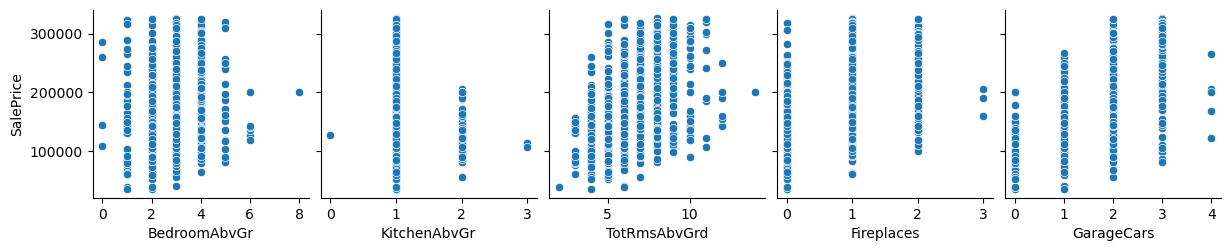

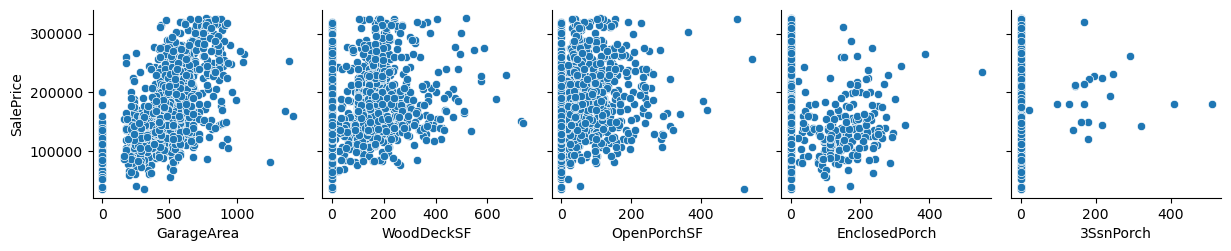

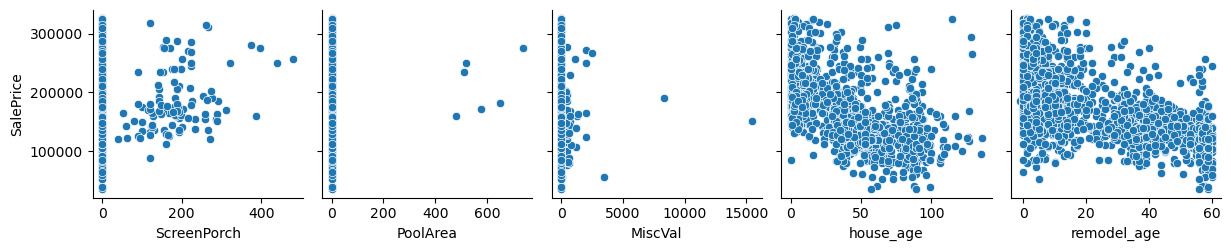

In [33]:
n_cols = num_col
n_cols = np.delete(n_cols, np.where(n_cols == 'SalePrice'))
for cols in n_cols.reshape(6,5):
    a_cols = cols
    cols = np.append(cols,'SalePrice')
    sns.pairplot(data=newdf[cols], x_vars=a_cols , y_vars='SalePrice')
    plt.show()

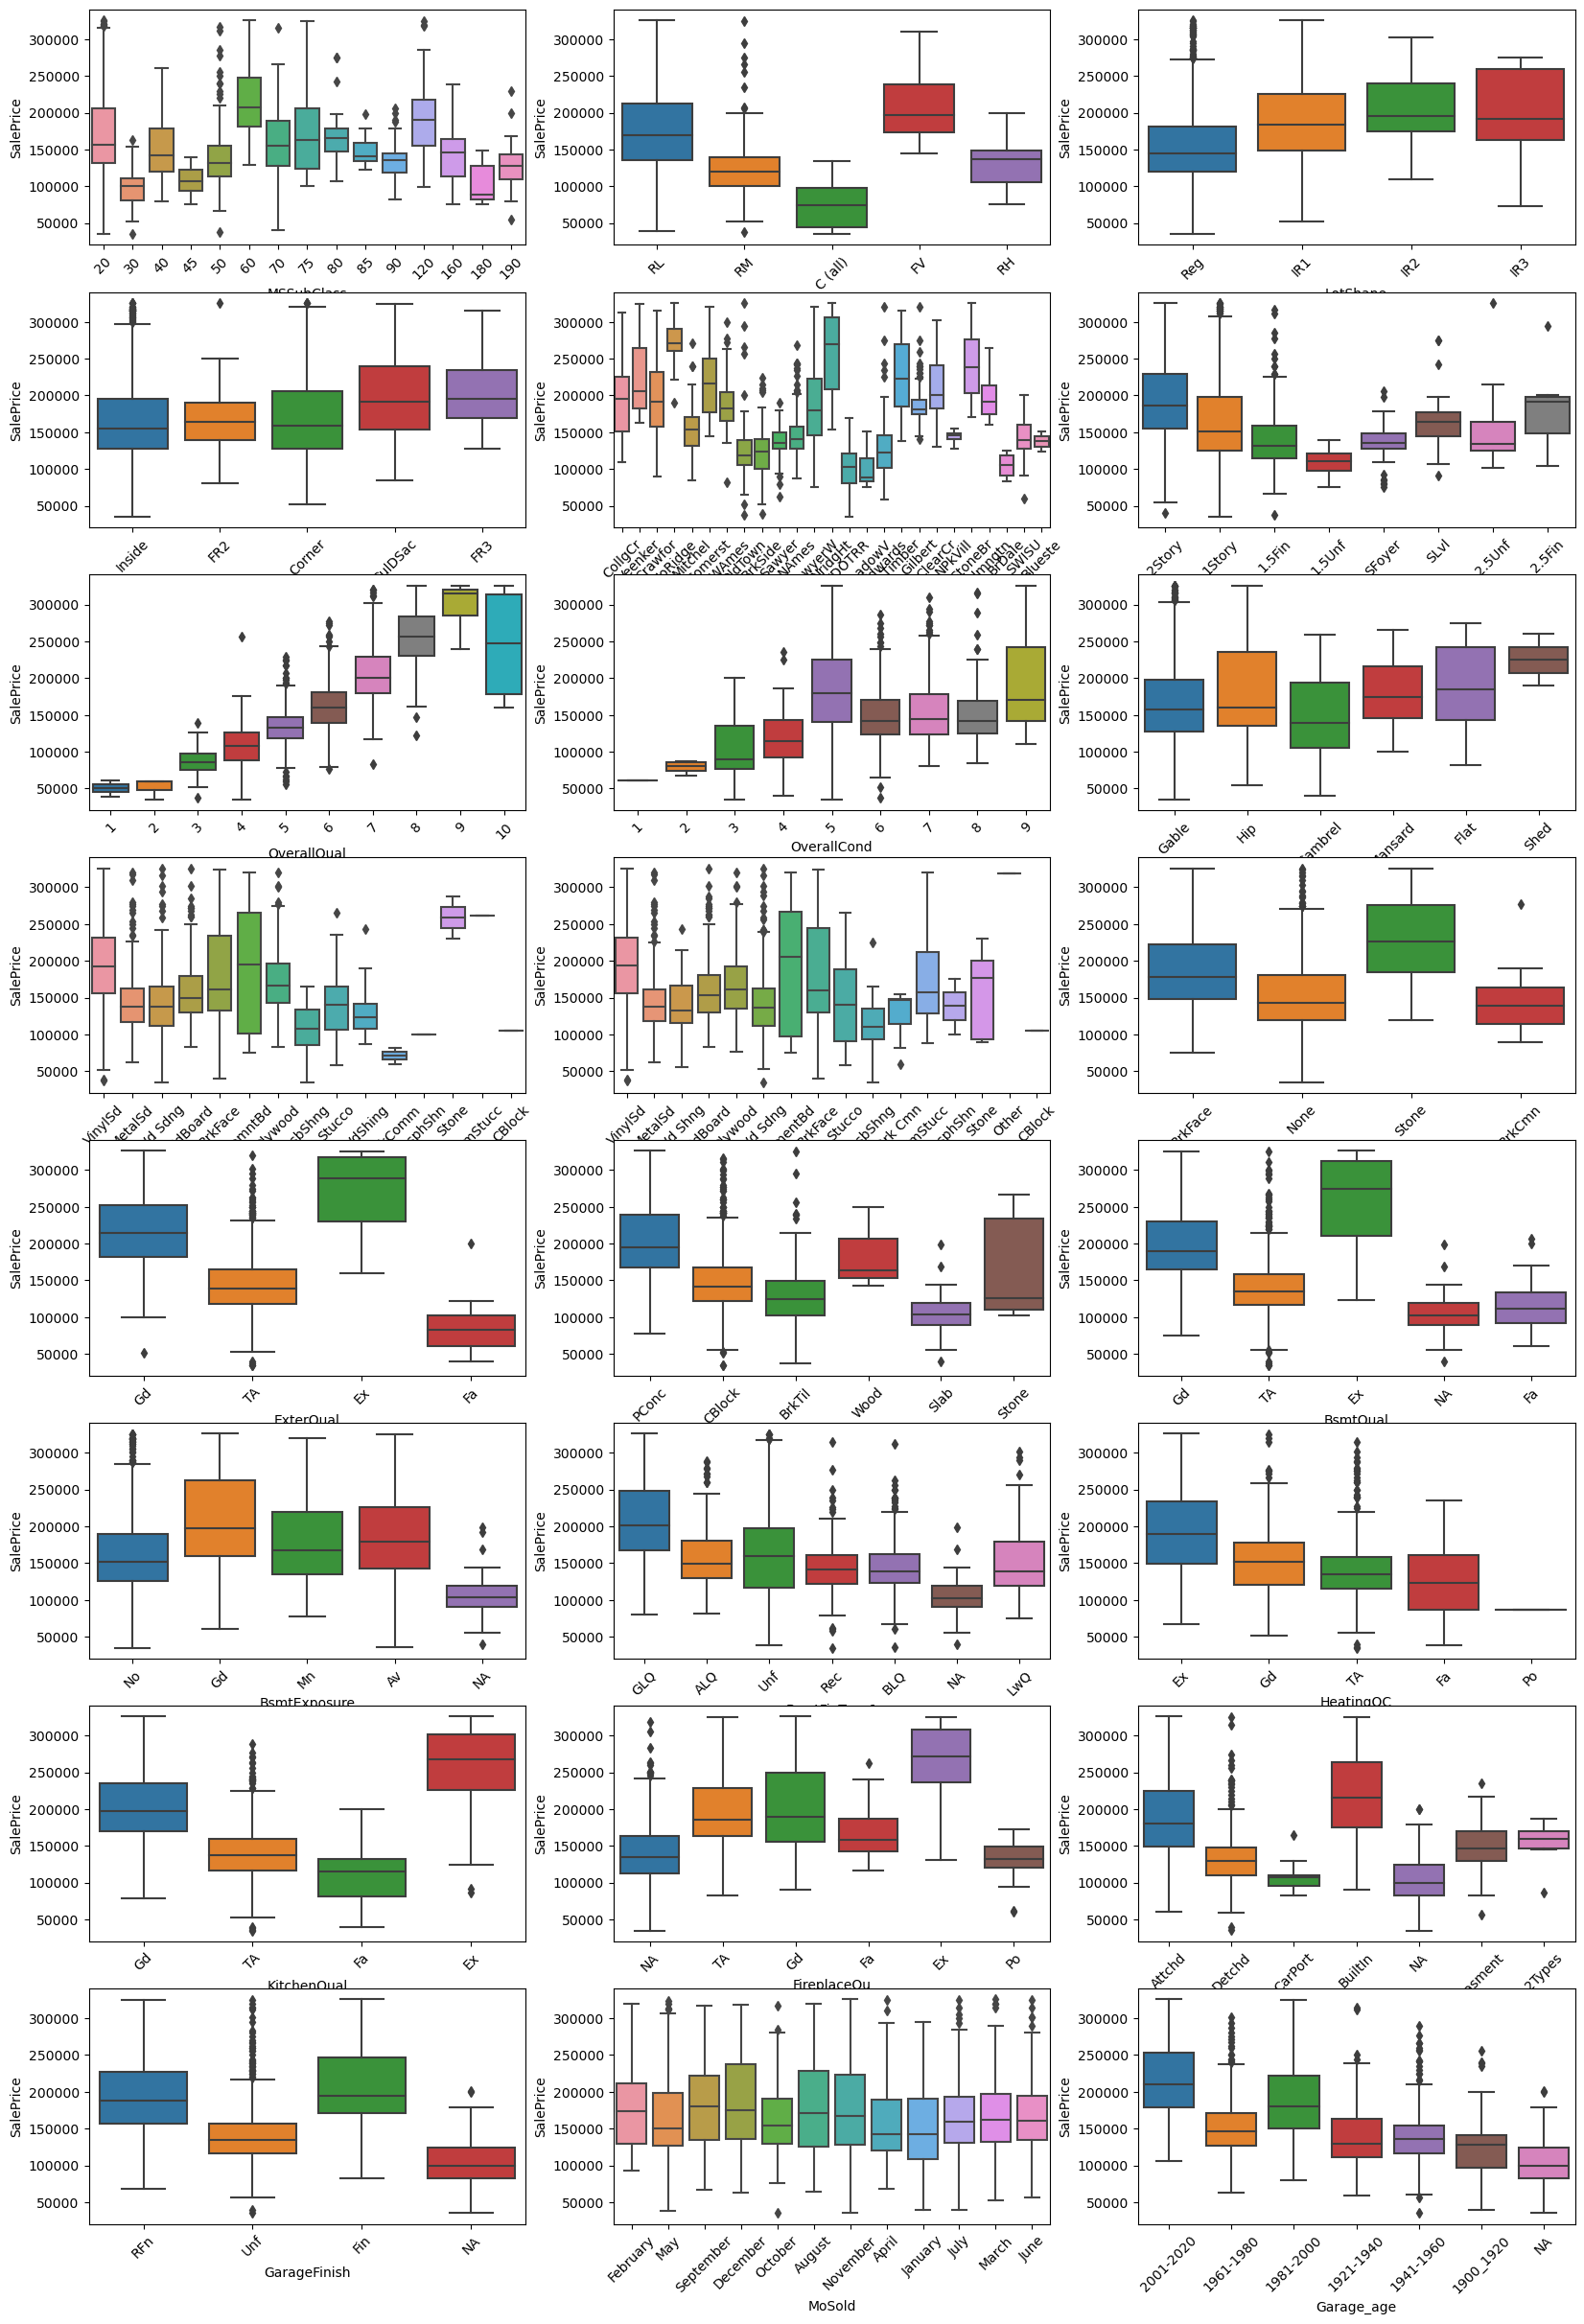

In [34]:
# Function to plot boxplot for categorical variables 
plt.figure(figsize=(20,30))
index=1
for col in cat_col:
    plt.subplot(8,3,index)
    sns.boxplot(x=col,y='SalePrice',data=newdf)
    plt.xticks(rotation=45)
    index+=1
plt.show()

#### Summary 
- There seems to be quite abit reduction in outliers. As data size is small, lets not delete lot of records.


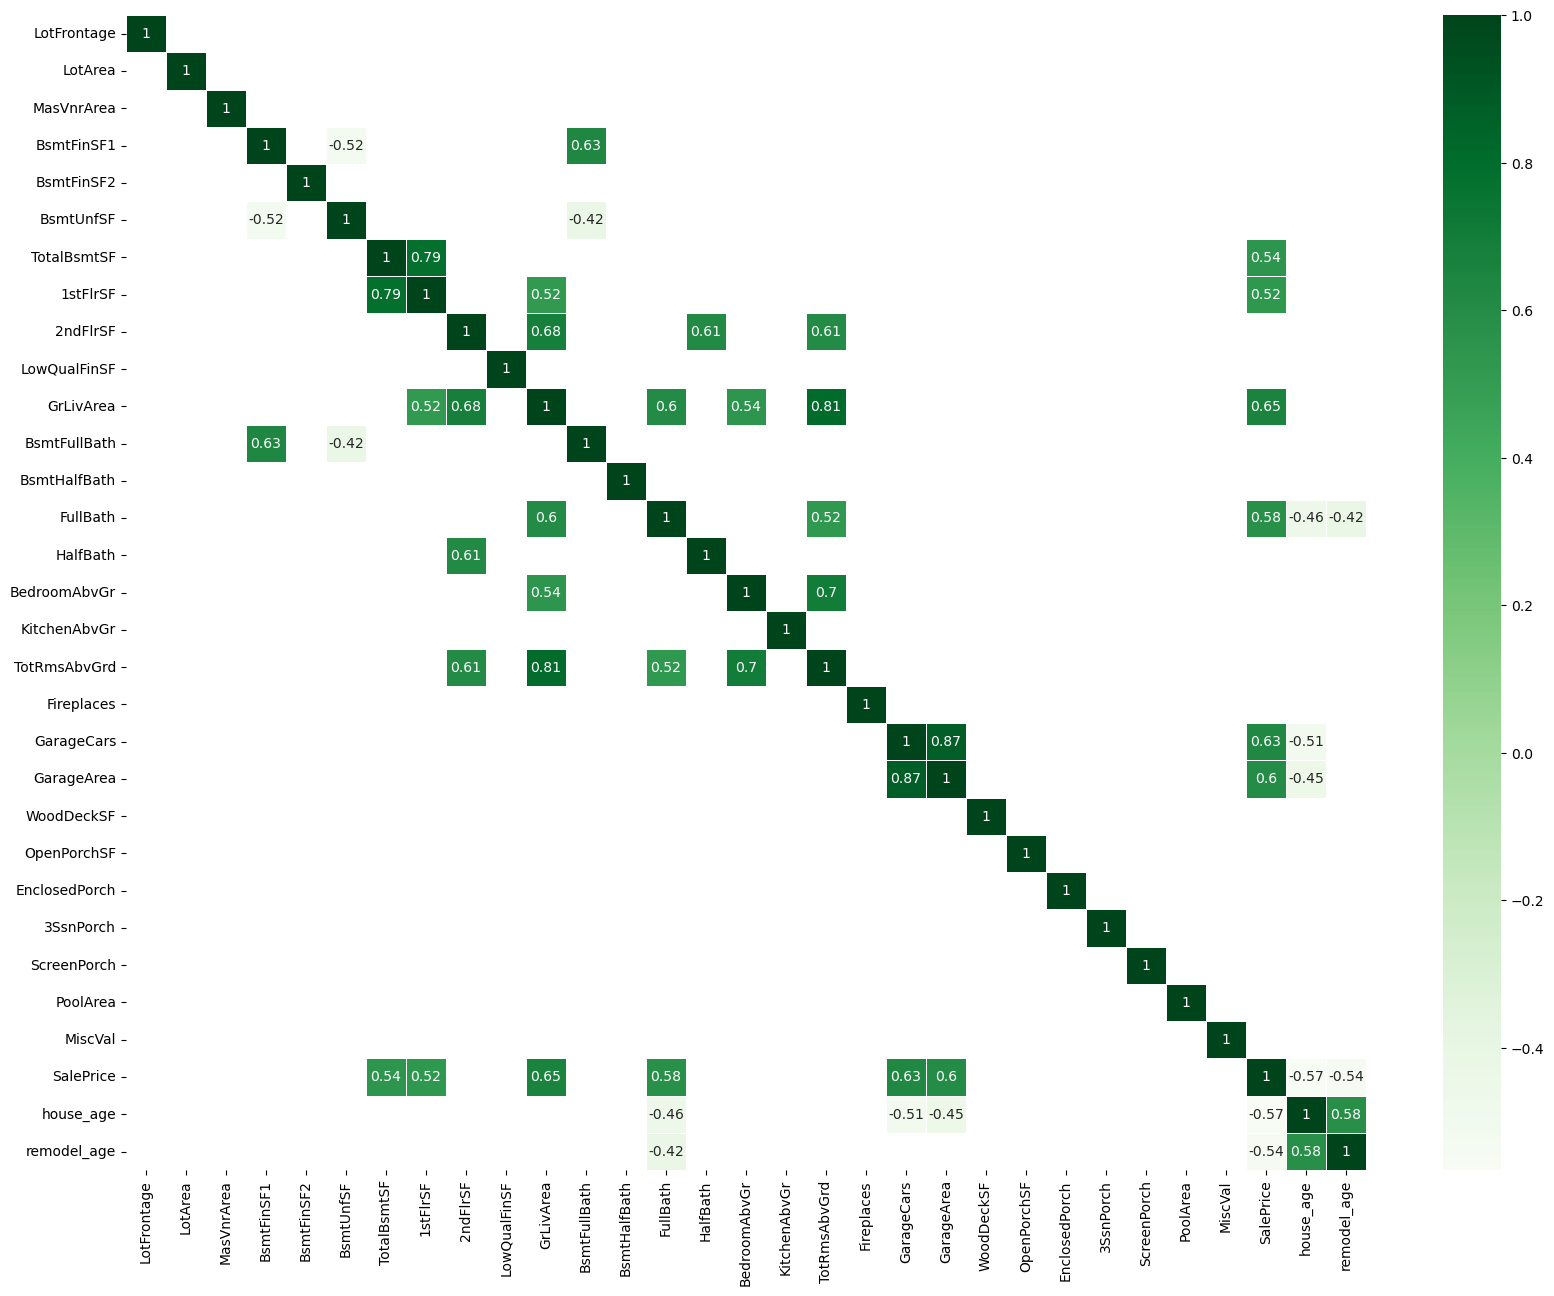

In [35]:
plt.figure(figsize=(20,15))

corr = newdf[num_col].corr()
sns.heatmap(corr[(corr >= 0.5) | (corr <= -0.4)],
            cmap='Greens',  linewidth=.5 ,
            annot=True);
plt.show()

### Data Preparation


#### One Hot Encoding on categorical variables

In [36]:
# Create Dummy Variables for categorical variable 
data= pd.get_dummies(newdf,columns=cat_col,drop_first=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1387 entries, 0 to 1459
Columns: 201 entries, LotFrontage to Garage_age_NA
dtypes: float64(2), int64(29), uint8(170)
memory usage: 577.0 KB


In [37]:
data.shape

(1387, 201)

In [38]:
print(data.columns.values)
print(cat_col)


['LotFrontage' 'LotArea' 'MasVnrArea' 'BsmtFinSF1' 'BsmtFinSF2'
 'BsmtUnfSF' 'TotalBsmtSF' '1stFlrSF' '2ndFlrSF' 'LowQualFinSF'
 'GrLivArea' 'BsmtFullBath' 'BsmtHalfBath' 'FullBath' 'HalfBath'
 'BedroomAbvGr' 'KitchenAbvGr' 'TotRmsAbvGrd' 'Fireplaces' 'GarageCars'
 'GarageArea' 'WoodDeckSF' 'OpenPorchSF' 'EnclosedPorch' '3SsnPorch'
 'ScreenPorch' 'PoolArea' 'MiscVal' 'SalePrice' 'house_age' 'remodel_age'
 'MSSubClass_30' 'MSSubClass_40' 'MSSubClass_45' 'MSSubClass_50'
 'MSSubClass_60' 'MSSubClass_70' 'MSSubClass_75' 'MSSubClass_80'
 'MSSubClass_85' 'MSSubClass_90' 'MSSubClass_120' 'MSSubClass_160'
 'MSSubClass_180' 'MSSubClass_190' 'MSZoning_FV' 'MSZoning_RH'
 'MSZoning_RL' 'MSZoning_RM' 'LotShape_IR2' 'LotShape_IR3' 'LotShape_Reg'
 'LotConfig_CulDSac' 'LotConfig_FR2' 'LotConfig_FR3' 'LotConfig_Inside'
 'Neighborhood_Blueste' 'Neighborhood_BrDale' 'Neighborhood_BrkSide'
 'Neighborhood_ClearCr' 'Neighborhood_CollgCr' 'Neighborhood_Crawfor'
 'Neighborhood_Edwards' 'Neighborhood_Gilbert' 

/Users/vineetsharma/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


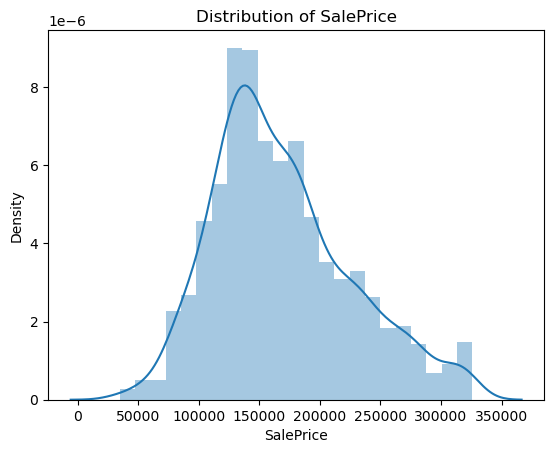

In [39]:
sns.distplot(data['SalePrice'])
plt.title('Distribution of SalePrice') # distribution of SalePrice column
plt.show()

In [40]:
data['SalePrice']= np.log(data["SalePrice"]) # applying log to SalePrice column

In [41]:
### Train / Test Splitting

In [42]:
### Data Scaling

In [43]:
df_train,df_test=train_test_split(data,train_size=0.7,random_state=0) # Split the data into train and test

In [44]:
scaler = MinMaxScaler()

In [45]:
df_train[num_col]=scaler.fit_transform(df_train[num_col]) 

In [46]:
df_test[num_col]= scaler.transform(df_test[num_col]) 

In [47]:
df_train.describe() 

,LotFrontage,LotArea,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,...,MoSold_May,MoSold_November,MoSold_October,MoSold_September,Garage_age_1921-1940,Garage_age_1941-1960,Garage_age_1961-1980,Garage_age_1981-2000,Garage_age_2001-2020,Garage_age_NA
count,970.000000,970.000000,970.000000,970.000000,970.000000,970.000000,970.000000,970.000000,970.000000,970.000000,...,970.000000,970.000000,970.000000,970.000000,970.000000,970.000000,970.000000,970.000000,970.000000,970.000000
mean,0.161930,0.055544,0.055879,0.073005,0.033107,0.290501,0.166092,0.181798,0.182588,0.011830,...,0.141237,0.053608,0.059794,0.046392,0.067010,0.146392,0.262887,0.215464,0.225773,0.057732
std,0.068303,0.050721,0.102848,0.076854,0.113058,0.222828,0.066914,0.081781,0.231230,0.093212,...,0.348446,0.225359,0.237227,0.210441,0.250169,0.353681,0.440428,0.411356,0.418306,0.233356
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.133562,0.038608,0.000000,0.000000,0.000000,0.114316,0.128314,0.122763,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.164384,0.050336,0.000000,0.065202,0.000000,0.242528,0.156956,0.168311,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.184932,0.062869,0.085938,0.120482,0.000000,0.418327,0.202005,0.228775,0.399615,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [48]:
# assigning X_train and y_train
y_train=df_train.pop('SalePrice')
X_train=df_train

In [49]:
# assigning X_test and y_test
y_test=df_test.pop('SalePrice')
X_test=df_test

In [50]:
X_train.shape

(970, 200)

In [51]:
X_test.shape

(417, 200)

In [52]:
#### Linear Regression

In [81]:
# linear regression with all predictors
lr = LinearRegression()
rfe = RFE(lr, n_features_to_select=35)
rfe = rfe.fit(X_train, y_train)

y_train_pred = rfe.predict(X_train)
print("r2 score for train :",r2_score(y_true=y_train, y_pred=y_train_pred))
y_test_pred = rfe.predict(X_test)
print("r2 score for test :",r2_score(y_true=y_test, y_pred=y_test_pred))

r2 score for train : 0.8648608922896182
r2 score for test : 0.7724395752183612


In [54]:
# Generic Method to Calulate VIF 
def calculateVIF(df):
    vif = pd.DataFrame({'feature': df.columns})
    vif['VIF'] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by = "VIF", ascending = False)
    return vif

In [55]:
# creating RFE DataFrame to easily access the output fo the RFE 
rfe_df = pd.DataFrame({'feature':X_train.columns, 'support':rfe.support_,'ranking':rfe.ranking_})
rfe_df.set_index('ranking',inplace=True)
rfe_df.sort_index(ascending=True)

,feature,support
ranking,,
1,LotFrontage,True
1,house_age,True
1,OverallCond_3,True
1,OverallCond_2,True
1,OverallQual_10,True
...,...,...
167,Neighborhood_NoRidge,False
168,LotConfig_CulDSac,False
169,Exterior1st_WdShing,False


In [56]:
#Selecting features frrom rfe output
rfe_columns = rfe_df[rfe_df.support].feature
rfe_columns

ranking
1            LotFrontage
1                LotArea
1            TotalBsmtSF
1               1stFlrSF
1               2ndFlrSF
1           BsmtFullBath
1           KitchenAbvGr
1             GarageCars
1                MiscVal
1              house_age
1            MSZoning_FV
1            MSZoning_RH
1            MSZoning_RL
1            MSZoning_RM
1           LotShape_IR3
1      HouseStyle_2.5Unf
1          OverallQual_2
1          OverallQual_3
1          OverallQual_4
1          OverallQual_5
1          OverallQual_6
1          OverallQual_7
1          OverallQual_8
1          OverallQual_9
1         OverallQual_10
1          OverallCond_2
1          OverallCond_3
1         RoofStyle_Shed
1    Exterior1st_BrkComm
1       Foundation_Stone
Name: feature, dtype: object

In [57]:
X_train_rfe = X_train[rfe_columns]
X_test_rfe = X_test[rfe_columns]

####  RIDGE MODEL

In [58]:
params = {'alpha': [0.00001, 0.0001, 0.001, 0.01, 0.05, 0.1, 
 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 
 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10, 20, 50, 100, 200, 500 ]} # hyperparameter

In [59]:
ridge = Ridge() # applying Ridge

folds = 5

model_ridge= GridSearchCV(estimator = ridge, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)

model_ridge.fit(X_train_rfe,y_train)

Fitting 5 folds for each of 29 candidates, totalling 145 fits


GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [1e-05, 0.0001, 0.001, 0.01, 0.05, 0.1, 0.2,
                                   0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0,
                                   3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10, 20,
                                   50, 100, 200, 500]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [60]:
cv_results = pd.DataFrame(model_ridge.cv_results_)
cv_results = cv_results[cv_results['param_alpha']<=500]
cv_results.head() 

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.003190,0.000969,0.001781,0.000445,0.00001,{'alpha': 1e-05},-0.042003,-0.047008,-0.042222,-0.048545,...,-0.044940,0.002580,6,-0.042532,-0.040746,-0.040816,-0.040778,-0.039872,-0.040949,0.000866
1,0.002046,0.000082,0.001433,0.000143,0.0001,{'alpha': 0.0001},-0.042003,-0.047008,-0.042221,-0.048545,...,-0.044940,0.002580,5,-0.042532,-0.040746,-0.040815,-0.040778,-0.039872,-0.040949,0.000866
2,0.002040,0.000097,0.001240,0.000035,0.001,{'alpha': 0.001},-0.042001,-0.047007,-0.042221,-0.048551,...,-0.044940,0.002582,4,-0.042533,-0.040746,-0.040815,-0.040778,-0.039872,-0.040949,0.000867
3,0.002035,0.000105,0.001235,0.000026,0.01,{'alpha': 0.01},-0.041989,-0.046995,-0.042212,-0.048607,...,-0.044937,0.002601,3,-0.042541,-0.040759,-0.040810,-0.040792,-0.039871,-0.040955,0.000869
4,0.002239,0.000344,0.001233,0.000019,0.05,{'alpha': 0.05},-0.041944,-0.046953,-0.042173,-0.048844,...,-0.044928,0.002682,2,-0.042580,-0.040870,-0.040877,-0.040881,-0.039920,-0.041026,0.000861


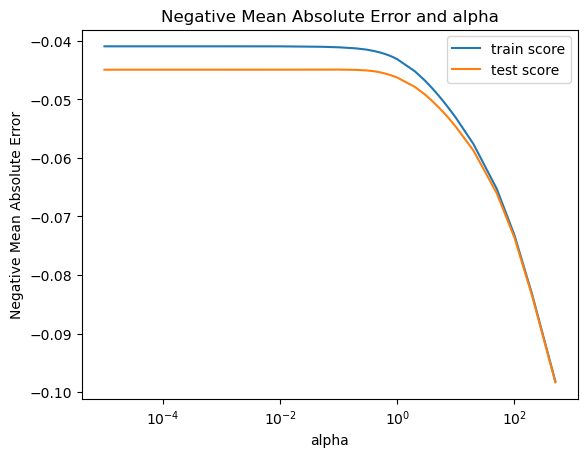

In [61]:
cv_results['param_alpha'] = cv_results['param_alpha'].astype('float32')

# plotting
plt.plot(cv_results['param_alpha'], cv_results['mean_train_score'])
plt.plot(cv_results['param_alpha'], cv_results['mean_test_score'])
plt.xlabel('alpha')
plt.ylabel('Negative Mean Absolute Error')
plt.xscale('log')
plt.title("Negative Mean Absolute Error and alpha")
plt.legend(['train score', 'test score'], loc='upper right')
plt.show()

In [62]:
model_ridge.best_params_

{'alpha': 0.1}

In [63]:
ridge=Ridge(alpha=model_ridge.best_params_['alpha'])
ridge_model=ridge.fit(X_train_rfe,y_train) 

In [64]:
y_pred_ridge=ridge_model.predict(X_test_rfe) 

In [65]:
r2_score(y_true=y_test,y_pred=y_pred_ridge) #r2 score on test data

0.7705072364243747

In [66]:
y_pred_train = ridge_model.predict(X_train_rfe)


print("RMSE train: {}".format(np.sqrt(mean_squared_error(y_train,y_pred_train))))
print("R2 score Train: {}".format(r2_score(y_train,y_pred_train)))
print(end = "\n\n")
print("RMSE test: {}".format(np.sqrt(mean_squared_error(y_test,y_pred_ridge))))
print("R2 score test: {}".format(r2_score(y_test,y_pred_ridge)))


RMSE train: 0.05848961194001977
R2 score Train: 0.8570229632982115


RMSE test: 0.07741400013482941
R2 score test: 0.7705072364243747


In [67]:
ridge_model.coef_ 

array([-0.02572781,  0.20122914,  0.21295399,  0.52861944,  0.21806162,
        0.07330573, -0.11944335,  0.14276453, -0.06381407, -0.10732632,
        0.24885598,  0.23387381,  0.24128203,  0.19027637, -0.07010287,
        0.18858904,  0.04263277,  0.08384983,  0.13438787,  0.18127489,
        0.2055195 ,  0.24788913,  0.29007229,  0.33791092, -0.19350737,
       -0.16503292, -0.10300152,  0.058404  , -0.11018483,  0.12079105])

In [68]:
ridge_model_parameter = list(ridge_model.coef_)
ridge_model_parameter.insert(0,ridge_model.intercept_)
cols = list(X_train_rfe.columns.values)
cols.insert(0,'constant')

ridge_coef = pd.DataFrame({'Feature':cols, 'Coef':ridge_model_parameter})
ridge_coef.sort_values(by='Coef',ascending=False).head(10)

,Feature,Coef
4,1stFlrSF,0.528619
24,OverallQual_9,0.337911
23,OverallQual_8,0.290072
11,MSZoning_FV,0.248856
22,OverallQual_7,0.247889
13,MSZoning_RL,0.241282
12,MSZoning_RH,0.233874
5,2ndFlrSF,0.218062
3,TotalBsmtSF,0.212954
21,OverallQual_6,0.205520


In [69]:
ridge_model.intercept_

0.0831399640840974

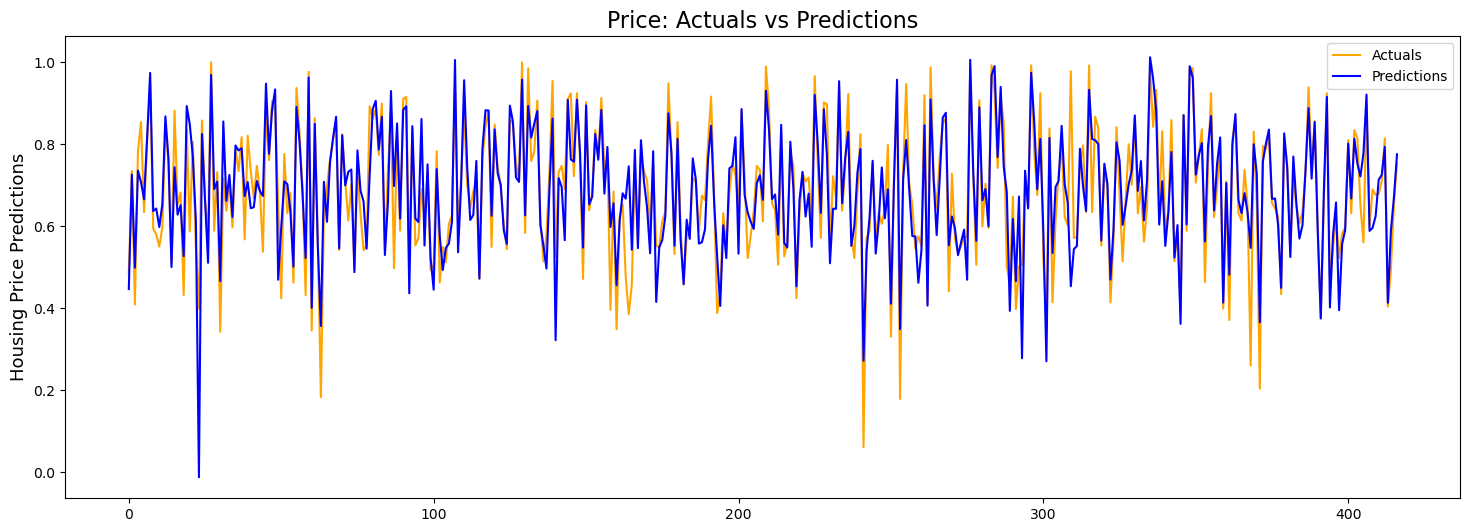

In [70]:
fig, ax=plt.subplots(figsize=(18,6))
sns.lineplot(x=range(len(y_pred_ridge)),y=y_test,label='Actuals',color='orange',ax=ax)
sns.lineplot(x=range(len(y_pred_ridge)),y=y_pred_ridge,label='Predictions',color='blue',ax=ax)
ax.set_title('Price: Actuals vs Predictions', fontsize=16)
ax.set_ylabel('Housing Price Predictions',fontsize=13) # Actual vs Predicted
plt.show()

### LASSO MODEL

In [71]:
lasso = Lasso() # applying Lasso

# cross validation
model_lasso = GridSearchCV(estimator = lasso, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            

model_lasso.fit(X_train_rfe, y_train) 

Fitting 5 folds for each of 29 candidates, totalling 145 fits


/Users/vineetsharma/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.575e-02, tolerance: 1.808e-03
  model = cd_fast.enet_coordinate_descent(
/Users/vineetsharma/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.994e-03, tolerance: 1.841e-03
  model = cd_fast.enet_coordinate_descent(
/Users/vineetsharma/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider in

GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [1e-05, 0.0001, 0.001, 0.01, 0.05, 0.1, 0.2,
                                   0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0,
                                   3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10, 20,
                                   50, 100, 200, 500]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [72]:
cv_results = pd.DataFrame(model_lasso.cv_results_)
cv_results = cv_results[cv_results['param_alpha']<=500]
cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.014457,0.001882,0.001751,0.000327,0.00001,{'alpha': 1e-05},-0.042304,-0.046980,-0.042203,-0.048843,...,-0.045015,0.002602,1,-0.042560,-0.040865,-0.040871,-0.040847,-0.039879,-0.041004,0.000866
1,0.005189,0.001248,0.001319,0.000071,0.0001,{'alpha': 0.0001},-0.043086,-0.047359,-0.041988,-0.050791,...,-0.045552,0.003179,2,-0.043109,-0.041762,-0.041585,-0.041800,-0.040474,-0.041746,0.000837
2,0.002514,0.000557,0.001321,0.000115,0.001,{'alpha': 0.001},-0.052995,-0.052311,-0.045409,-0.056975,...,-0.051897,0.003722,3,-0.051040,-0.049235,-0.048927,-0.050004,-0.050786,-0.049999,0.000829
3,0.002151,0.000094,0.001286,0.000082,0.01,{'alpha': 0.01},-0.089827,-0.088110,-0.075583,-0.084246,...,-0.084226,0.004938,4,-0.083121,-0.083884,-0.084364,-0.082140,-0.083784,-0.083458,0.000769
4,0.002208,0.000330,0.001298,0.000143,0.05,{'alpha': 0.05},-0.126924,-0.122340,-0.115398,-0.121810,...,-0.121435,0.003690,5,-0.119986,-0.121160,-0.122873,-0.121291,-0.121619,-0.121386,0.000926


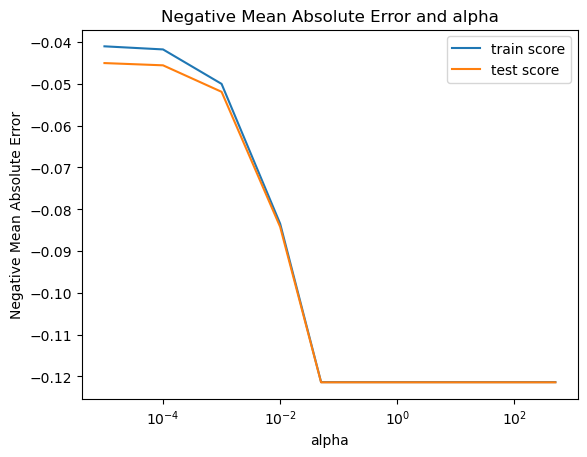

In [73]:
cv_results['param_alpha'] = cv_results['param_alpha'].astype('float32')

# plotting
plt.plot(cv_results['param_alpha'], cv_results['mean_train_score'])
plt.plot(cv_results['param_alpha'], cv_results['mean_test_score'])
plt.xlabel('alpha')
plt.ylabel('Negative Mean Absolute Error')
plt.xscale('log')
plt.title("Negative Mean Absolute Error and alpha")
plt.legend(['train score', 'test score'], loc='upper right')
plt.show()

In [74]:
model_lasso.best_params_ # best hyperparameter


{'alpha': 1e-05}

In [75]:
lasso=Lasso(alpha=model_lasso.best_params_['alpha'])
lasso_model=lasso.fit(X_train_rfe,y_train) 

/Users/vineetsharma/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.168e-02, tolerance: 2.321e-03
  model = cd_fast.enet_coordinate_descent(


In [76]:
y_pred_lasso=lasso_model.predict(X_test_rfe)
r2_score(y_true=y_test,y_pred=y_pred_lasso) 

0.7683168709759591

In [77]:
lasso_model.coef_ 

array([-0.02559304,  0.20384587,  0.20299194,  0.54484625,  0.21920329,
        0.0733713 , -0.12211617,  0.14068392, -0.05766553, -0.10771889,
        0.25846988,  0.24370082,  0.24983967,  0.19919433, -0.06964123,
        0.19365651,  0.07475658,  0.1161029 ,  0.16673211,  0.21322203,
        0.23733179,  0.27960358,  0.32178997,  0.3719309 , -0.17095505,
       -0.16787668, -0.10080545,  0.05353594, -0.11364353,  0.12501065])

In [78]:
y_pred_train = lasso_model.predict(X_train_rfe)
print("RMSE train: {}".format(np.sqrt(mean_squared_error(y_train,y_pred_train))))
print("R2 score Train: {}".format(r2_score(y_train,y_pred_train)))
print(end = "\n\n")
print("RMSE test: {}".format(np.sqrt(mean_squared_error(y_test,y_pred_lasso))))
print("R2 score test: {}".format(r2_score(y_test,y_pred_lasso)))

RMSE train: 0.058409631966368544
R2 score Train: 0.8574137158031364


RMSE test: 0.07778255701197417
R2 score test: 0.7683168709759591


In [79]:
lasso_model_parameter = list(lasso_model.coef_)
lasso_model_parameter.insert(0,lasso_model.intercept_)
cols = list(X_train_rfe.columns.values)
cols.insert(0,'constant')
lasso_coef = pd.DataFrame({'Feature':cols, 'Coef':ridge_model_parameter})
lasso_coef.sort_values(by='Coef',ascending=False).head(10)

,Feature,Coef
4,1stFlrSF,0.528619
24,OverallQual_9,0.337911
23,OverallQual_8,0.290072
11,MSZoning_FV,0.248856
22,OverallQual_7,0.247889
13,MSZoning_RL,0.241282
12,MSZoning_RH,0.233874
5,2ndFlrSF,0.218062
3,TotalBsmtSF,0.212954
21,OverallQual_6,0.205520


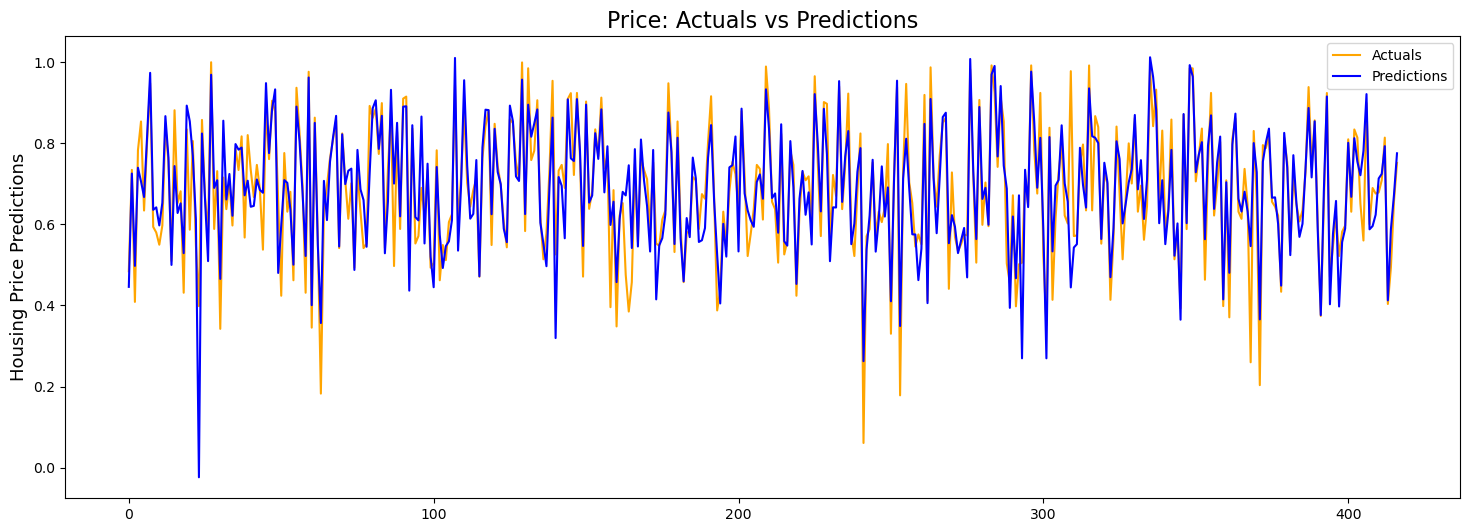

In [80]:
fig, ax=plt.subplots(figsize=(18,6))
sns.lineplot(x=range(len(y_pred_lasso)),y=y_test,label='Actuals',color='orange',ax=ax)
sns.lineplot(x=range(len(y_pred_lasso)),y=y_pred_lasso,label='Predictions',color='blue',ax=ax)
ax.set_title('Price: Actuals vs Predictions', fontsize=16)
ax.set_ylabel('Housing Price Predictions',fontsize=13)
plt.show()